<a href="https://colab.research.google.com/github/hkuennemann/Deep-Learning-PyTorch/blob/main/03_PyTorch_Computer_Vision/03_pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Wed Feb 26 17:42:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.5.1+cu124


'cuda'

## 1. What are 3 areas in industry where computer vision is currently being used?

Self-driving cars, assembly lines, surveillance, etc.

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Creating a model that matches (memorizes) the training set so closely that the model fails to make correct predictions on new data -> fails to generalize.

## 3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each.
> **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.

- *Cross-validation*: Not having a single train-test split, but dividing the dataset into multiple folds where each fold acts like the test set once is a great way to prevent overfitting.
- *Train with more data*: It won't work every time, but training with more data can help algorithms detect the signal better.
- *Remove features*: If too many features are given to the algorithm, insignificant noise can cause overfitting. Thus, more is not always better!
- *Early stopping*: Stopping the algorithm at a certain threshold in one performance metric can help reducing overfitting as the improvement beyond this threshold is often only memorizing the train set.
- *Regularization*: Similar to 'remove features' above.
- *Ensembling*: Having a diverse array of different models, i.e. different opinions, can help reducing overfitting.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [4]:
len(train_data), len(test_data)

(60000, 10000)

In [5]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
# See first training example
image, label = train_data[0]

# Check the shape of our image
print(f"Image shape: {image.shape} -> [color_channels, height, width]")
print(f"Label: {label}")

Image shape: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Label: 5


## 6. Visualize at least 5 different samples of the MNIST training dataset.

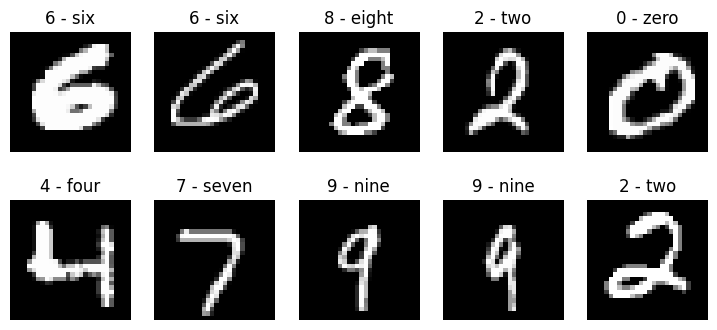

In [7]:
import matplotlib.pyplot as plt

# Plot ten images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 4))
rows, cols = 2, 5
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False)

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [8]:
# set up hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_Dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

test_Dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False) # For evaluation it is usually easier to NOT shuffle

print(train_Dataloader, test_Dataloader)
print(f"Length of train DataLoader: {len(train_Dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test Dataloader: {len(test_Dataloader)} batches of {BATCH_SIZE}...")

<torch.utils.data.dataloader.DataLoader object at 0x7a42e06d6650> <torch.utils.data.dataloader.DataLoader object at 0x7a42e06ea1d0>
Length of train DataLoader: 1875 batches of 32...
Length of test Dataloader: 313 batches of 32...


## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [9]:
from torch import nn

# Create a convolutional neural network
class MNISTModel(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):

    super().__init__()

    self.conv_block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units * 7 * 7,
                out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    #print(f"Output shape of conv_block_1: {x.shape}")
    x = self.classier(x)
    #print(f"Output shape of classifier: {x.shape}")
    return x

In [10]:
torch.manual_seed(42)
model = MNISTModel(input_shape=1,
                   hidden_units=10,
                   output_shape=len(train_data.classes)).to(device)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [11]:
def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               accuracy_fn,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  """Trains a PyTorch model for a single epoch."""
  train_loss, train_acc = 0, 0

  model.to(device)

  # Put model on train
  model.train()

  # Add a loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
    #Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate the loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulatively add up the loss per epoch
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1))

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total train loss and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}")


def test_step(model: nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Tests a PyTorch model for a single epoch."""

  ### Testing
  test_loss, test_acc = 0, 0

  # Put model on device
  model.to(device)

  # Put model in eval mode
  model.eval()

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through testing batches
    for X, y in data_loader:
      # Send data to device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate the loss
      test_loss += loss_fn(test_pred, y)

      # 3. Calculate the accuracy
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss and accuracy average per batch
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    # Print out what's happening
    print(f"\nTest loss: {test_loss:.5f}, Test acc: {test_acc:.2f}")

In [12]:
import requests
from pathlib import Path

# Download helper functions from github repo
link = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(requests.get(link).content)

helper_functions.py already exists, skipping download


In [13]:
# Setup loss function / evaluation metrics / optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

In [14]:
from timeit import default_timer as timer

def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [15]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
train_time_start = timer()

# Set the number of epochs (keep this small for faster training time)
EPOCHS = 5

# Create training and test loop
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_step(model=model,
               data_loader=train_Dataloader,
               loss_fn=loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=optimizer)

    ### Testing
    test_step(model=model,
              data_loader=test_Dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn)

# Calculate training time
train_time_end = timer()
total_train_time = print_train_time(start=train_time_start,
                                    end=train_time_end,
                                    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.33304 | Train acc: 88.87

Test loss: 0.07217, Test acc: 97.74
Epoch: 1
-------
Train loss: 0.08094 | Train acc: 97.48

Test loss: 0.06623, Test acc: 97.86
Epoch: 2
-------
Train loss: 0.06310 | Train acc: 98.02

Test loss: 0.05364, Test acc: 98.15
Epoch: 3
-------
Train loss: 0.05441 | Train acc: 98.31

Test loss: 0.05894, Test acc: 98.01
Epoch: 4
-------
Train loss: 0.04908 | Train acc: 98.54

Test loss: 0.04432, Test acc: 98.44
Train time on cuda: 56.334 seconds


## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [16]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass
      pred_logit = model(sample)

      # Get prediction probability
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [25]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

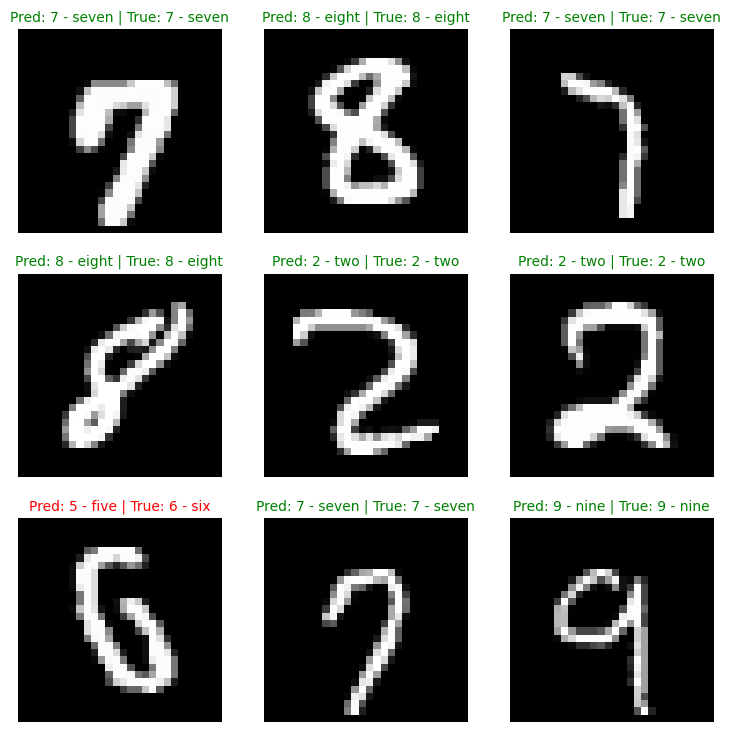

In [26]:
# Make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

# Convert prediction probabilties to labels
pred_classes = pred_probs.argmax(dim=1)

# Plot predictions
plt.figure(figsize=(9, 9))

nrows = 3
ncols = 3

for i, smaple in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the sample
  plt.imshow(smaple.squeeze(), cmap="gray")

  # Find the prediction
  pred_label = train_data.classes[pred_classes[i]]

  # Get the true label
  true_label = train_data.classes[test_labels[i]]

  # Set the title
  title_text = f"Pred: {pred_label} | True: {true_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == true_label:
    plt.title(title_text, fontsize = 10, c="g")
  else:
    plt.title(title_text, fontsize = 10, c="r")

  # Remove ticks
  plt.axis("off")

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [28]:
# install torchmetrics
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

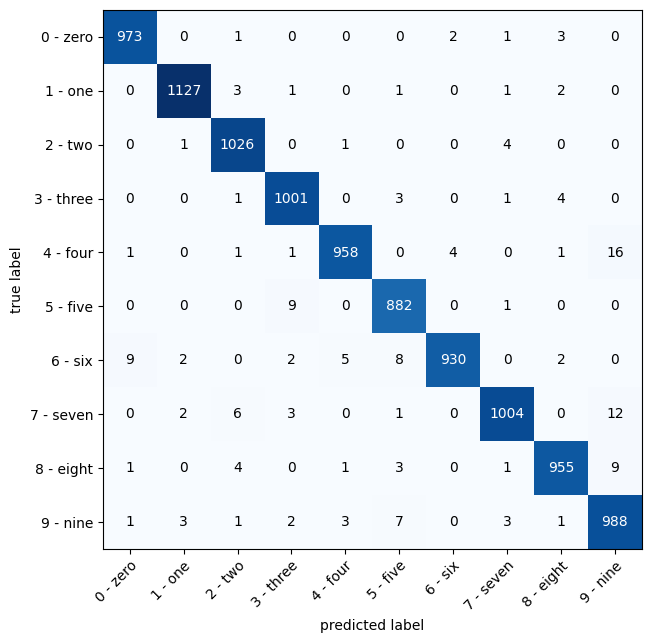

In [29]:
import mlxtend

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_Dataloader, desc="Making predictions..."):
    # Send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do forward pass
    y_logits = model(X)
    #Turn predictions from logits -> pred probabilities -> pred labels
    y_pred = torch.softmax(y_logits.squeeze(), dim=1).argmax(dim=1)
    # Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion instance and compare predictions to targets
confmat = ConfusionMatrix(task='multiclass', num_classes = len(train_data.classes))
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat = confmat_tensor.numpy(),
                                class_names = train_data.classes,
                                figsize = (10, 7))

## 12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?

In [30]:
random_tensor = torch.rand(size=(1, 3, 64, 64))
random_tensor.shape

torch.Size([1, 3, 64, 64])

In [36]:
conv_layer = nn.Conv2d(in_channels = 3,
                       out_channels = 10,
                       kernel_size = 6,
                       stride = 2,
                       padding = 2)

conv_output = conv_layer(random_tensor)

conv_output.shape

torch.Size([1, 10, 32, 32])

The higher the kernel size, the smalller the output shape.

## 13. Use a model similar to the trained `model_2` from notebook 03 to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
* Then plot some predictions where the model was wrong alongside what the label of the image should've been.
* After visualing these predictions do you think it's more of a modelling error or a data error?
* As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

In [65]:
# Get train and test data
fashion_train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)
fashion_test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [66]:
# Get the class names of the Fashion MNIST dataset
fashion_mnist_class_names = fashion_train_data.classes
fashion_mnist_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [67]:
# set up hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
fashion_train_Dataloader = torch.utils.data.DataLoader(dataset=fashion_train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True)

fashion_test_Dataloader = torch.utils.data.DataLoader(dataset=fashion_test_data,
                                              batch_size=BATCH_SIZE,
                                              shuffle=False) # For evaluation it is usually easier to NOT shuffle

print(fashion_train_Dataloader, fashion_test_Dataloader)
print(f"Length of train DataLoader: {len(fashion_train_Dataloader)} batches of {BATCH_SIZE}...")
print(f"Length of test Dataloader: {len(fashion_test_Dataloader)} batches of {BATCH_SIZE}...")

<torch.utils.data.dataloader.DataLoader object at 0x7a416ffaec10> <torch.utils.data.dataloader.DataLoader object at 0x7a416fe8b6d0>
Length of train DataLoader: 1875 batches of 32...
Length of test Dataloader: 313 batches of 32...


In [68]:
torch.manual_seed(42)
fashion_model = MNISTModel(input_shape=1,
                           hidden_units=10,
                           output_shape=len(fashion_train_data)).to(device)

In [69]:
# Setup loss function and optimizer
fashion_loss_fn = nn.CrossEntropyLoss()
fashion_optimizer = torch.optim.SGD(params=fashion_model.parameters(), lr=0.1)

In [70]:
# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
fashion_train_time_start = timer()

# Set the number of epochs (keep this small for faster training time)
EPOCHS = 5

# Create training and test loop
for epoch in tqdm(range(EPOCHS)):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_step(model=fashion_model,
               data_loader=fashion_train_Dataloader,
               loss_fn=fashion_loss_fn,
               accuracy_fn=accuracy_fn,
               optimizer=fashion_optimizer)

    ### Testing
    test_step(model=fashion_model,
              data_loader=fashion_test_Dataloader,
              loss_fn=fashion_loss_fn,
              accuracy_fn=accuracy_fn)

# Calculate training time
fashion_train_time_end = timer()
fashion_total_train_time = print_train_time(start=fashion_train_time_start,
                                    end=fashion_train_time_end,
                                    device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Train loss: 0.87317 | Train acc: 72.50

Test loss: 0.40737, Test acc: 85.58
Epoch: 1
-------
Train loss: 0.38736 | Train acc: 85.94

Test loss: 0.38573, Test acc: 86.34
Epoch: 2
-------
Train loss: 0.34872 | Train acc: 87.42

Test loss: 0.34482, Test acc: 87.48
Epoch: 3
-------
Train loss: 0.32952 | Train acc: 88.09

Test loss: 0.32633, Test acc: 88.25
Epoch: 4
-------
Train loss: 0.31724 | Train acc: 88.49

Test loss: 0.32734, Test acc: 88.53
Train time on cuda: 62.939 seconds


In [73]:
# Make predictions with trained model
test_preds = []
fashion_model.eval()
with torch.inference_mode():
  for X_test, y_test in tqdm(fashion_test_Dataloader):
    y_logits = fashion_model(X_test.to(device))
    y_pred_probs = torch.softmax(y_logits, dim=1)
    y_pred_labels = torch.argmax(y_pred_probs, dim=1)
    test_preds.append(y_pred_labels)
test_preds = torch.cat(test_preds).cpu() # matplotlib likes CPU
test_preds[:10], len(test_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

(tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7]), 10000)

In [74]:
fashion_test_data.targets[:10]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [75]:
# Get wrong prediction indexes
import numpy as np
wrong_pred_indexes = np.where(test_preds != fashion_test_data.targets)[0]
len(wrong_pred_indexes)

1148

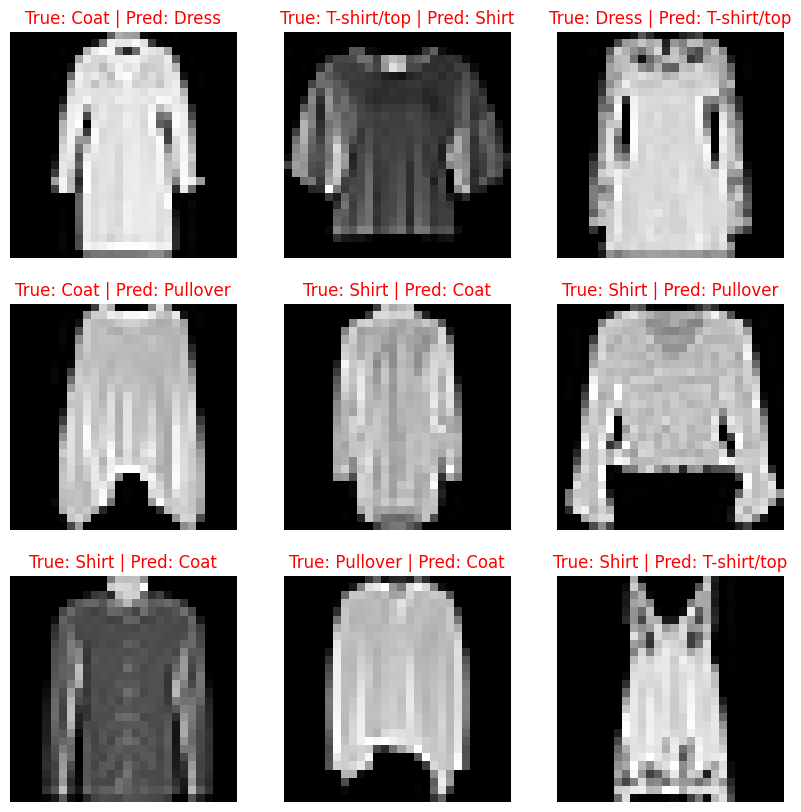

In [77]:
# Select random 9 wrong predictions and plot them
import random
random_selection = random.sample(list(wrong_pred_indexes), k=9)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_selection):
  # Get true and pred labels
  true_label = fashion_mnist_class_names[fashion_test_data[idx][1]]
  pred_label = fashion_mnist_class_names[test_preds[idx]]

  # Plot the wrong prediction with its original label
  plt.subplot(3, 3, i+1)
  plt.imshow(fashion_test_data[idx][0].squeeze(), cmap="gray")
  plt.title(f"True: {true_label} | Pred: {pred_label}", c="r")
  plt.axis(False);

The labeling is clearly confusing. I would, just like the model did, also make mistakes in predicting those given labels.